In [2]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dropout, Dense 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from keras_preprocessing import sequence
from keras_preprocessing.text import Tokenizer

from transformers import BertTokenizer, TFBertModel

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

import os

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from collections import Counter

import nltk
import re
# nltk.download('punkt')

In [61]:
# Check for TensorFlow GPU access
print(tf.config.list_physical_devices())

# See TensorFlow version
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.13.0


In [90]:
data_path = os.path.join('data')
train_name = 'train/dataset_penyisihan_bdc_2024(in).csv'
train = pd.read_csv(os.path.join(data_path, train_name), delimiter=';')

In [16]:
# train.head()

,text,label
0,Kunjungan Prabowo ini untuk meresmikan dan men...,Sumber Daya Alam
1,RT Anies dapat tepuk tangan meriah saat jadi R...,Politik
2,@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= ...,Demografi
3,RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7...,Politik
4,Anies Baswedan Harap ASN termasuk TNI dan Polr...,Politik


In [17]:
# train['label'].value_counts()

label
Politik                    2972
Sosial Budaya               587
Pertahanan dan Keamanan     400
Ideologi                    400
Ekonomi                     367
Sumber Daya Alam            192
Demografi                    62
Geografi                     20
Name: count, dtype: int64

<Axes: xlabel='label'>

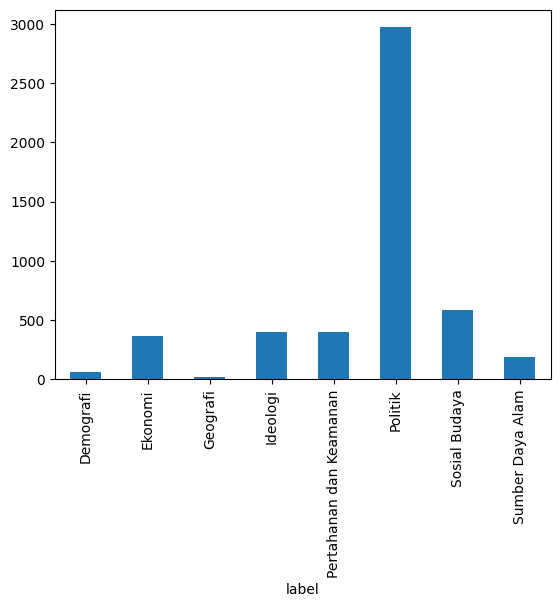

In [18]:
# train.groupby('label').size().plot(kind='bar')

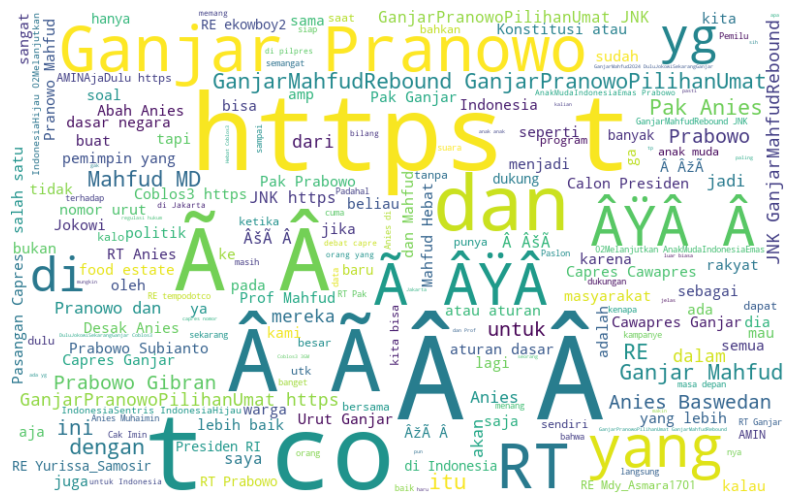

In [19]:
def wordCloud(words):
    wordCloud = WordCloud(width=800, height=500, background_color='white', random_state=21, max_font_size=120).generate(words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis('off')

all_words = ' '.join([text for text in train['text']])
wordCloud(all_words)

In [91]:
# Load stopwords 
def load_stopwords(filepath):
    with open(filepath, 'r') as file:
        stop_words = set(file.read().splitlines())
    return stop_words

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def reduce_repeated_characters(text):
    return re.sub(r'(.)\1{2,}', r'\1\1', text)

def preprocess_text(text, stop_words, stemmer):
    # Lowercase 
    text = text.lower()
    text = reduce_repeated_characters(text)
    # Remove punctuation, '=', ',', startwith(@), word 'rt' with another character
    text = re.sub(r"#\w+", ' ', text)
    text = re.sub(r"\s*[/@+]\w+|\brt\b|[=,.()/:#!?'&-]\s*|rt(?=\W)|\b\w{1,4}\b|\[[^\]]*\]|(?<=\w),(?=\w)|https?", ' ', text)
    text = re.sub(r'[^A-Za-z0-9 ]', ' ', text)
    text = re.sub(r'\b(\w+)\d+\b', r'\1', text)
    # Remove stopwords and specific word
    filtered_words = [word for word in text.split() if word.lower() not in stop_words and word.lower()]
    # filtered_words = ''.join(filtered_words)
    # Stemming
    stemmed_words = [stemmer.stem(word) for word in filtered_words]
    # Join stemmed words
    return ' '.join(stemmed_words)


def preprocess_dataframe(df, column_name, stop_words, stemmer):
    df[column_name] = df[column_name].apply(lambda x: preprocess_text(x, stop_words, stemmer))
    return df
    

stopwords = load_stopwords(os.path.join(data_path, 'stopwords_indonesia.txt'))
df = train.copy()
train_cleaned = preprocess_dataframe(df, 'text', stopwords, stemmer).dropna()

csv_file = "train_cleaned.csv"
train_cleaned.to_csv(os.path.join(data_path, csv_file), index=False)
# print("Write CSV Done.")
# train_cleaned = pd.read_csv(os.path.join(data_path, csv_file), delimiter=',')
train_cleaned.head()

,text,label
0,kunjung prabowo resmi serah proyek bantu bersi...,Sumber Daya Alam
1,anies tepuk tangan riah rektor wajib kuliah ko...,Politik
2,bener dukung goblok dukung ridwan kamil skema ...,Demografi
3,anies sikap kritis kerja prabowo anggap engga ...,Politik
4,anies baswedan harap polri pegang sumpah milu,Politik


In [97]:
train_cleaned = pd.read_csv(os.path.join(data_path, csv_file), delimiter=',').dropna()
train_cleaned.head()
print(train_cleaned.shape)

(4990, 2)


In [98]:
# jumlah_hapus = 2500
# hapus_idx = train_cleaned[train_cleaned['label'] == 5].sample(n=jumlah_hapus, random_state=42).index
# train_cleaned = train_cleaned.drop(hapus_idx)


max_jumlah = 300

# Mengiterasi setiap kategori di label
for label in train_cleaned['label'].unique():
    jumlah_data = train_cleaned[train_cleaned['label'] == label].shape[0]
    if jumlah_data > max_jumlah:
        hapus_idx = train_cleaned[train_cleaned['label'] == label].sample(n=jumlah_data - max_jumlah, random_state=42).index
        train_cleaned = train_cleaned.drop(hapus_idx)

# Memverifikasi hasil
for label in train_cleaned['label'].unique():
    print(f"Label {label} memiliki {train_cleaned[train_cleaned['label'] == label].shape[0]} data.")

Label Sumber Daya Alam memiliki 191 data.
Label Demografi memiliki 62 data.
Label Politik memiliki 300 data.
Label Pertahanan dan Keamanan memiliki 300 data.
Label Sosial Budaya memiliki 300 data.
Label Ideologi memiliki 300 data.
Label Ekonomi memiliki 300 data.
Label Geografi memiliki 18 data.


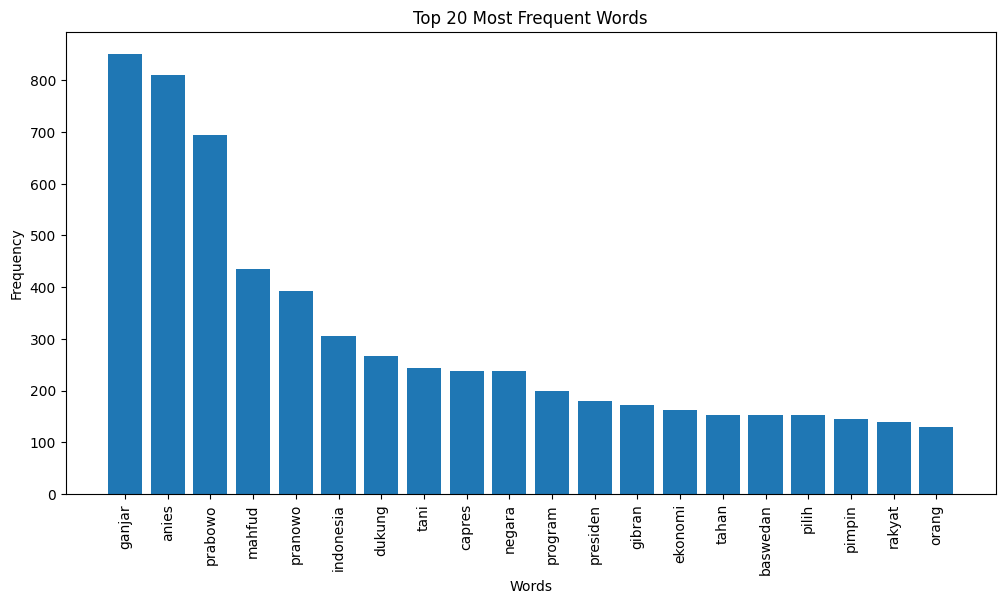

In [99]:
all_text = ' '.join(train_cleaned['text'])

word_counts = Counter(all_text.split())
most_common_words = word_counts.most_common(20) 
words, counts = zip(*most_common_words)

plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Words')
plt.xticks(rotation=90)
plt.show()

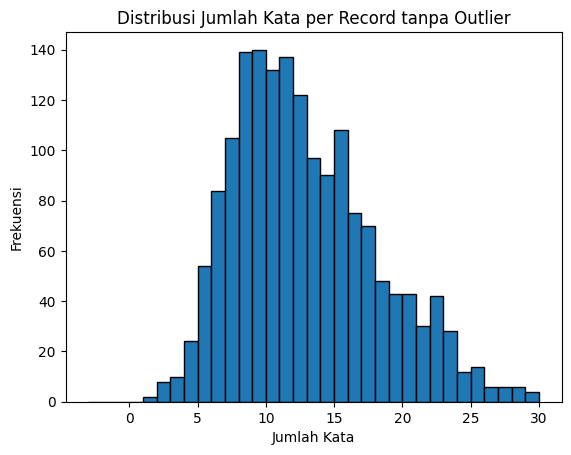

(1679, 2)


In [100]:
def count_words(text):
    return len(word_tokenize(text))

train_cleaned['word_count'] = train_cleaned['text'].apply(count_words)

# Menghitung Q1, Q3, dan IQR
Q1 = train_cleaned['word_count'].quantile(0.25)
Q3 = train_cleaned['word_count'].quantile(0.75)
IQR = Q3 - Q1

# Mendefinisikan batas bawah dan batas atas untuk outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Menghapus outlier
train_cleaned = train_cleaned[(train_cleaned['word_count'] >= lower_bound) & (train_cleaned['word_count'] <= upper_bound)]

# Menampilkan histogram tanpa outlier
plt.hist(train_cleaned['word_count'], bins=range(int(lower_bound), int(upper_bound) + 2), edgecolor='black')
plt.title('Distribusi Jumlah Kata per Record tanpa Outlier')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()
train_cleaned = train_cleaned.drop(columns=['word_count'])
print(train_cleaned.shape)

In [ ]:
# # Wordcloud after cleaning
# all_words = ' '.join([text for text in train_cleaned['text']])
# wordCloud(all_words)

In [101]:
# Initialize the distribution strategy
strategy = tf.distribute.MirroredStrategy()

# Define the tokenizer and BERT model within the strategy scope
with strategy.scope():
    tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
    bert_model = TFBertModel.from_pretrained("indobenchmark/indobert-base-p1")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Some layers from the model checkpoint at indobenchmark/indobert-base-p1 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [102]:
def bert_token(texts, tokenizer):
    tokens = tokenizer(list(texts), add_special_tokens=True,
                      max_length=120,
                      padding='max_length',
                      truncation=True,
                      return_tensors='tf')
    return np.array(tokens['input_ids']), np.array(tokens['attention_mask'])
    

In [54]:
# from gensim.models import Word2Vec

# sg_model = Word2Vec(vector_size=300, sg=1, workers=2, window=5)

In [55]:
# max_len = 100

# tokenizer_sg = Tokenizer()
# tokenizer_sg.fit_on_texts(train_cleaned['text'])

# sequences = tokenizer_sg.texts_to_sequences(train_cleaned['text'])
# data = sequence.pad_sequences(sequences, maxlen=max_len)
# print(data)

In [56]:
# vocab_size = len(tokenizer_sg.word_index) + 1
# embedding_matrix = np.zeros((vocab_size, 300))

# # Use items() method to iterate over word_index dictionary
# for word, i in tokenizer_sg.word_index.items():
#     if word in sg_model.wv:
#         embedding_matrix[i] = sg_model.wv[word]


In [103]:
X = train_cleaned['text'].astype(str)
y = train_cleaned['label']

In [104]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# encoding labels: Encode target labels with values between 0 and n_classes-1.
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)

# Convert labels to one-hot encoding using to_categorical
y = to_categorical(y_encoded)


In [105]:
print(X.shape, y.shape)
indices = np.arange(X.shape[0])

# Split the data along with the indices
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X, y, indices, test_size=0.2, random_state=42, stratify=y
)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1679,) (1679, 8)
(1343,) (1343, 8) (336,) (336, 8)


In [60]:
# y_test.value_counts()

In [106]:
# Tokenize train and test data
train_input_ids, train_attention_masks = bert_token(X_train, tokenizer)
test_input_ids, test_attention_masks = bert_token(X_test, tokenizer)

In [62]:
# train_embeddings = bert_model([train_input_ids, train_attention_masks])[0][:, 0, :].numpy()
# test_embeddings = bert_model([test_input_ids, test_attention_masks])[0][:, 0, :].numpy()

In [63]:
# # Train an SVM classifier
# svm_classifier = svm.SVC(kernel='linear')
# svm_classifier.fit(train_embeddings, y_train)

# # Predict using the test embeddings
# test_predictions = svm_classifier.predict(test_embeddings)

# # Evaluate the classifier
# accuracy = accuracy_score(y_test, test_predictions)
# print(f'Accuracy: {accuracy}')
# print('Classification Report:')
# print(classification_report(y_test, test_predictions))

In [14]:
# Class weights
from sklearn.utils.class_weight import compute_class_weight
y_train_single = np.stack(y).argmax(axis=1)
classes = np.unique(y_train_single)
weights = compute_class_weight('balanced', classes=classes, y=y_train_single)
class_weights = {k: v for k, v in zip(classes, weights)}
print('Class weights:', class_weights)

Class weights: {0: 10.183189655172415, 1: 1.7119565217391304, 2: 32.8125, 3: 1.5834450402144773, 4: 1.5919811320754718, 5: 0.20716415292879692, 6: 1.1164933837429112, 7: 3.28125}


In [107]:

# Use a smaller BERT model like DistilBERT
# bert_model = TFBertModel.from_pretrained("distilbert-base-uncased")
bert_model.trainable = True

# Define the model
def build_model():
    input_ids = tf.keras.Input(shape=(120,), dtype=tf.int32, name='input_ids')
    input_masks = tf.keras.Input(shape=(120,), dtype=tf.int32, name='attention_mask')

    X = bert_model([input_ids, input_masks])
    cls_token = X.last_hidden_state[:, 0, :]
    cls_token_ = tf.keras.layers.Reshape((768, 1))(cls_token)

    x = tf.keras.layers.Conv1D(filters=64, kernel_size=4, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(cls_token_)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x_out = tf.keras.layers.Dense(8, activation='sigmoid')(x)

    model = tf.keras.models.Model(inputs=[input_ids, input_masks], outputs=x_out)
    return model


# Compile model with learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True)

# strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = build_model()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Add callbacks for early stopping and checkpointing
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)

model.summary()


Model: "model_34"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 120)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 120)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_9 (TFBertMod  TFBaseModelOutputWithPooli   1244413   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   44         'attention_mask[0][0]']      
                             hidden_state=(None, 120, 7                                    

In [108]:
# Train the model
history = model.fit(
    [train_input_ids, train_attention_masks],
    y_train,
    validation_data=([test_input_ids, test_attention_masks], y_test),
    epochs=10,
    batch_size=64,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10


2024-05-23 12:13:25.519199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 12:13:25.529587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2024-05-23 12:13:51.750479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [60]:
bert_model.trainable = True
def build_model():
    with strategy.scope():
        
        input_ids = tf.keras.Input(shape=(120,), dtype=tf.int32, name='input_ids')
        input_masks = tf.keras.Input(shape=(120,), dtype=tf.int32, name='attention_mask')
    
        X = bert_model([input_ids, input_masks])
        cls_token = X[0][:, 0, :]
        cls_token_ = tf.keras.layers.Reshape((768, 1))(cls_token)
    
        x = tf.keras.layers.Conv1D(filters=256, 
                                   kernel_size=4,
                                   activation='relu', 
                                   kernel_regularizer=tf.keras.regularizers.l2(0.01))(cls_token_)
        # x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dropout(0.4)(x)
        x = tf.keras.layers.Dense(units=256, activation='relu',
                                 kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
        x_out = tf.keras.layers.Dense(8, activation='sigmoid')(x)
        model = tf.keras.models.Model(inputs=[input_ids, input_masks], outputs=x_out)
    return model

# Build the model
model = build_model()
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5), 
          loss='binary_crossentropy', 
          metrics=['accuracy'])
model.summary()

ValueError: Variable (MirroredVariable:{
  0: <tf.Variable 'tf_bert_model_7/bert/embeddings/word_embeddings/weight:0' shape=(50000, 768) dtype=float32, numpy=
array([[-0.0314744 , -0.0320593 , -0.0157246 , ...,  0.01264481,
        -0.01124867, -0.00791191],
       [ 0.0079074 ,  0.04750701, -0.01753412, ...,  0.01659925,
        -0.03737387, -0.00554099],
       [-0.02490235,  0.02469621, -0.01339187, ...,  0.01084628,
        -0.01839368, -0.00454293],
       ...,
       [-0.0268713 , -0.00894849, -0.02756262, ...,  0.00585391,
         0.00343511, -0.04975013],
       [-0.04224312, -0.03423494, -0.01052536, ...,  0.06707171,
         0.00978042, -0.03562831],
       [-0.02691879, -0.01918597,  0.00372241, ...,  0.02549149,
         0.00376727, -0.04998587]], dtype=float32)>
}) was not created in the distribution strategy scope of (<tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x292029ca0>). It is most likely because some layers, model, or optimizer was being created outside the distribution strategy scope. Try to make sure your code looks similar to the following.
with strategy.scope():
  model=_create_model()
  model.compile(...)

In [15]:
checkpoint_filepath = 'ckp/epoch-{epoch:02d}-val_accuracy-{val_accuracy:.2f}.h5'

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  
    monitor='val_accuracy',  
    mode='max',              
    save_best_only=True     
)


early_stopping = EarlyStopping(
    monitor='accuracy',  
    mode='max',          
    patience=0,          
    verbose=1,           
    baseline=0.90,       
    restore_best_weights=True  
)

In [16]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    y_train,
    validation_data=([test_input_ids, test_attention_masks], y_test),
    epochs=10,
    batch_size=64,
    callbacks=[checkpoint_callback, early_stopping]
)

Epoch 1/10


2024-05-23 01:47:44.943365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 01:47:44.953733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2024-05-23 01:47:56.424619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 5/60 [=>............................] - ETA: 30:31 - loss: 5.6092 - accuracy: 0.4688

In [ ]:
# Extract accuracy and validation loss
accuracy = history.history['accuracy']
val_loss = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

# Plot accuracy and validation loss
plt.figure(figsize=(10, 6))

plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training Accuracy and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()

plt.show()

# TEKAN KENE SIK

In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
y_preds = np.around(model.predict(X_test))

y_true = pd.DataFrame(y_test)
y_preds = pd.DataFrame(y_preds)

print(confusion_matrix(y_true, y_preds))

In [ ]:
embedding_layer=Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=100, trainable=False)

In [ ]:
# from tensorflow.keras.regularizers import l2
# sequence_length = 100  # This should match your actual input sequence length
# embedding_dim = 256  # This should match the output dimension of your embedding layer

# # Assuming embedding_layer is already defined and correct
# embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_length)


In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=256, kernel_size=1, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          4670700   
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 256)          77056     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 50, 256)           0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_1 (Dropout)         (None, 12800)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               3277056   
                                                      

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=32
)

Epoch 1/5


ValueError: in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/src/engine/training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/src/backend.py", line 6626, in pool2d
        x = tf.compat.v1.nn.max_pool(

    ValueError: Exception encountered when calling layer 'max_pooling1d_1' (type MaxPooling1D).
    
    Negative dimension size caused by subtracting 2 from 1 for '{{node sequential_1/max_pooling1d_1/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 1, 1], padding="VALID", strides=[1, 2, 1, 1]](sequential_1/max_pooling1d_1/ExpandDims)' with input shapes: [32,1,1,256].
    
    Call arguments received by layer 'max_pooling1d_1' (type MaxPooling1D):
      • inputs=tf.Tensor(shape=(32, 1, 256), dtype=float32)


In [ ]:
def evaluate_classification(data_true, data_predicted, target_names):
    # Print classification report
    report = classification_report(data_true, data_predicted)
    print("Classification Report:")
    print(report)

    # Generate confusion matrix
    cm = confusion_matrix(data_true, data_predicted)

    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()